In [2]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import pickle
import os
import sys
from osgeo import ogr
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from scipy.optimize import minimize
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon,shape
from shapely.strtree import STRtree  
import glob
import time

sys.path.insert(1, '../../Modeles3D/test_3D/')
from Rouss3D import *

sys.path.insert(1, '../../Modeles2D/test_premier_model/')
# hand made functions
from Rouss1 import *
from Rouss2 import *

sys.path.insert(1,"../../Model_val/upscalling/")
from upscalling_functions import*

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [3]:
model_dir = "working"
model_name = "2etest_3D"
exe_name= "../../exe/mf6"

In [4]:
R_path="../../data/shp/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer
Q_path = "../../data/shp/entités/Q_merge.shp"
P_path = "../../data/shp/entités/Plio_merge.shp"

#rivers paths
Agly_path = "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path = "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

#stations paths
Agly_stations = "../../data/Fleuves/stations_agly.csv" 
Tet_stations = "../../data/Fleuves/stations_tet2.csv"
Rea_stations = "../../data/Fleuves/stations_reart.csv"
Tech_stations = "../../data/Fleuves/stations_tech.csv"
Bol_stations = "../../data/Fleuves/stations_bol.csv"
Cant_stations = "../../data/Fleuves/stations_cant.csv"



In [5]:
#spatial parameters

MNT_path = "../../data/MNT/MNT_50.tif"
x0,y0,x1,y1 = get_MNTbbox(MNT_path)

Lx = x1-x0
Ly = y1-y0
nlay = 3
res = 300

ncol = int(Lx/res)
nrow = int(Ly/res)

delr = np.ones(ncol)*res
delc = np.ones(nrow)*res

idomain = np.zeros(([nlay,nrow,ncol]))

grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data

In [6]:
# top

Rast = Raster.load(MNT_path)
top = Rast.resample_to_grid(grid.xcellcenters,
                      grid.ycellcenters,
                      band = Rast.bands[0],
                      method="nearest")

In [7]:
Q_IDs = gp2cellids3D(grid,gp.read_file(Q_path),idomain,layer=0)

In [8]:
Pl_IDs = gp2cellids3D(grid,gp.read_file(P_path),idomain,layer=1)

In [9]:
idomain[2] = idomain[1] # same extent for PMS than PC

In [11]:
botm = np.ones([nlay,nrow,ncol])

## ne sert à rien
# surfaces synthethiques

#Q
botm[0] = top.copy()
botm[0][idomain[0]==1] = top[idomain[0]==1] - 10
botm[0][idomain[0]!=1] -= 1


#Pliocene
x = np.linspace(1,200,ncol)
y = np.linspace(1,1,nrow)
ep,Y = np.meshgrid(x,y)
ep *= 0.5

botm[1][idomain[1]==1] = (botm[0] - ep)[idomain[1]==1]
botm[1][idomain[1]!=1] -= 1

botm[2] = botm[1] - 50

In [12]:
#tentative d'une meilleure dis

#PC
surf = Raster.load("../../data/txt_couches_nouv/s3_mur_pc.txt")
botm[1] = surf.resample_to_grid(grid.xcellcenters,
                      grid.ycellcenters,
                      band = surf.bands[0],
                      method="nearest")
mask = (botm[1]==-9999) & (idomain[1]==1)
botm[1][mask]=botm[0][mask]-20 # épaisseur minimale de 20

#PMS
surf = Raster.load("../../data/txt_couches_nouv/s4_mur_pms.txt")
botm[2] = surf.resample_to_grid(grid.xcellcenters,
                      grid.ycellcenters,
                      band = surf.bands[0],
                      method="nearest")
mask = (botm[2]==-9999) & (idomain[2]==1)
botm[2][mask]=botm[1][mask]-20

In [13]:
def MinThick(idomain,botm,top,min_ep=10):
    """
    Change the thickness of certains active cells based on a criterion (min_ep)
    Can also be used to change cells with negative thickness
    
    idomain : 3d list (nlay,nrow,ncol)
    botm : the list containing the surfaces of all the layers
    top : the top surface
    min_ep : int, the minimum thickness tolerate
    
    """
    
    for ilay in range(botm.shape[0]-1):
        mask = ((botm[ilay] - botm[ilay+1])< min_ep) & (idomain[ilay+1]==1)
        botm[ilay][mask] = botm[ilay+1][mask] + min_ep

    mask = ((top-botm[0])<=0) & (idomain[0]==1)
    top[mask] = botm[0][mask] + min_ep
    

In [14]:
# attribute a minimum thickness 
MinThick(idomain,botm,top)

In [15]:
# Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[ilay,irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))


In [16]:
#uppermost active cell
Up_cells_act = up_act_cell(idomain)

In [17]:
# BC sea
# import the shapefile that correspond to the BC
BCsea_path = "../../data/shp/Sea_BC_L93.shp"
BC_sea = gp.read_file(BCsea_path)

# extract cellids from the BC at the sea and make these cells active
lst_chd = gp2cellids3D(grid,BC_sea,idomain,type="line",idomain_active=True)

# attribute a constant head at all the cells in the lst_chd
CHD = 0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [18]:
# BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.SHP"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]

# extract cellids from the BC 
etangs_chd = gp2cellids3D(grid,etangs.dissolve(by="NATURE"),idomain,idomain_active=True)

# attribute a constant head
CHD = 0; et_chd_lst=[];
for x in etangs_chd:
    et_chd_lst.append((x,CHD))
    lst_chd.append(x)

In [19]:
Agy_chd = Complete_riv(Agly_path,Agly_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tech_chd = Complete_riv(Tech_path,Tech_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Cant_chd = Complete_riv(Cant_path,Cant_stations,28,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Rea_chd = Complete_riv(Rea_path,Rea_stations,100,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Tet_chd = Complete_riv(Tet_path,Tet_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
Bol_chd = Complete_riv(Bol_path,Bol_stations,180,0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)

C:\Users\emmal\Anaconda3\lib\site-packages\pandas\core\frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [20]:
# extraction
path = "../../data/prélèvements/BD_FORAGES_SMNPR/SMNPRV2.shp"

stress_data_well = importWells3D(path,grid,lst_domain,V_col="V_A_AEMRC", geol_col="NAPPE_CAPT",
                                 geol_layer=["PLIOCENE","QUATERNAIRE"],layer_num=[1,0])

In [78]:
#permea
k = 1e-4

In [59]:
def ImportControlPz3D(piez_path,sheet_name,geol_layer,layer_num,geol_col,grid,nlay,np_col="NP",x_col="x",y_col="y"):
    
    """
    return an 3D array containing infos about piezometer level in control pz in a multiple layers model$
    the null value is set to 0
    
    piez_path : str, the file path to the excel sheet
    sheet_name : str, the name of the data sheet 
    geol_layer : lst, the name of the different lithology
    layer_num : lst, the ilay number which corresponds to the lithology in geol_layer
    geol_col : the name of the colum containing lithologies
    grid and nlay : grid and number of layers of the model
    np_col : str, the name of the column containing infos about the PL
    x_col,y_col : str, the name of the columns containings geo infos
    """
    
    piez_path="../../data/piezos/pz_hydriad.xlsx"
    data = pd.read_excel(piez_path,sheet_name=sheet_name)

    geol_layer = geol_layer
    layer_num = layer_num

    Control_pz = np.zeros([nlay,grid.nrow,grid.ncol]) #ini list

    for ilay in range(len(geol_layer)): # go through each different lithology
        lstIDpz=[]
        Pz=[]
        DB = data[data[geol_col]==geol_layer[ilay]]
        DB.reset_index(inplace=True)
        for o in np.arange(DB.shape[0]): # loop to iterate through the data and returns the intersected cellids
            xc = DB[x_col][o]
            yc = DB[y_col][o] 
            cellid = grid.intersect(xc,yc)

            if not np.isnan(DB[np_col][o]):
                lstIDpz.append(cellid)
                Pz.append(DB[np_col][o])

        df = pd.DataFrame()
        df["cellid"]=lstIDpz
        df["Pz"] = Pz
        df = df.groupby(["cellid"]).mean().reset_index()

        for i in df.index:
            j,k = df.loc[i,"cellid"]
            Control_pz[layer_num[ilay],j,k] = df.loc[i,"Pz"]

    return Control_pz

In [60]:
piez_path="../../data/piezos/pz_hydriad.xlsx"
Control_Pz = ImportControlPz3D(piez_path,sheet_name="1960",geol_layer=["Quaternaire","Pliocène"],layer_num=[0,1],geol_col="AquifèreCapté",
                 grid=grid,nlay=nlay)

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [61]:
#recharge
rch_path = "../../data/recharge/rast_peff2.tif"
rcha = import_rch(rch_path,grid)

rch_lst=[]
for icell in Up_cells_act:
    ilay = icell[0]
    irow = icell[1]
    icol = icell[2]
    rch_lst.append(((icell),rcha[irow,icol]/1000/365/86400))
            

In [62]:
# drains everywhere

drn_areas=inter_lst(Up_cells_act,lst_chd,typ="unique")
lst_drn=[]
for cellid in drn_areas:
    i = cellid[0]
    j = cellid[1]
    k = cellid[2]
    
    xc = grid.xcellcenters[j,k]
    yc = grid.ycellcenters[j,k]
    
    lst_drn.append(((i,j,k),top[j,k]-1,0.01))

In [88]:
# basic modules

sim = fp.mf6.MFSimulation(sim_name='first3D_mf6', version='mf6', exe_name=exe_name, 
                         sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)

tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')


# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=botm+1)


# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'ALL')])


# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=k, save_flows=True,save_specific_discharge=True)


# recharge
#rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400)
rch = fp.mf6.ModflowGwfrch(gwf,maxbound=len(rch_lst),stress_period_data=rch_lst,save_flows=True)


#drain
drn = fp.mf6.ModflowGwfdrn(gwf,pname="sup_flow",maxbound=len(lst_drn),stress_period_data=lst_drn)

#well
wel = fp.mf6.ModflowGwfwel(gwf,pname="wel",maxbound=len(stress_data_well),
                           stress_period_data=stress_data_well,save_flows=True)

#chd
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

etangs = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='eta', filename="eta.chd", maxbound=len(et_chd_lst), 
                                               stress_period_data={0: et_chd_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='agy', filename="agy.chd", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tet', filename="Tet.chd", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Rea', filename="Rea.chd", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Cant', filename="Cant.chd", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Tech', filename="Tech.chd", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='Bol', filename="Bol.chd", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)


In [89]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model 2etest_3D...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rch_0...
    writing package sup_flow...
    writing package wel...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Al

(True, [])

In [130]:
# retrieve heads and spdis 
head = get_heads(model_name,model_dir)
spdis = get_spdis(model_name,model_dir)

# retrieve the chd package name
bdfile=[]
for file in os.listdir(model_dir):
    if file.endswith(".chd"):
        bdfile.append(os.path.splitext(file)[0])

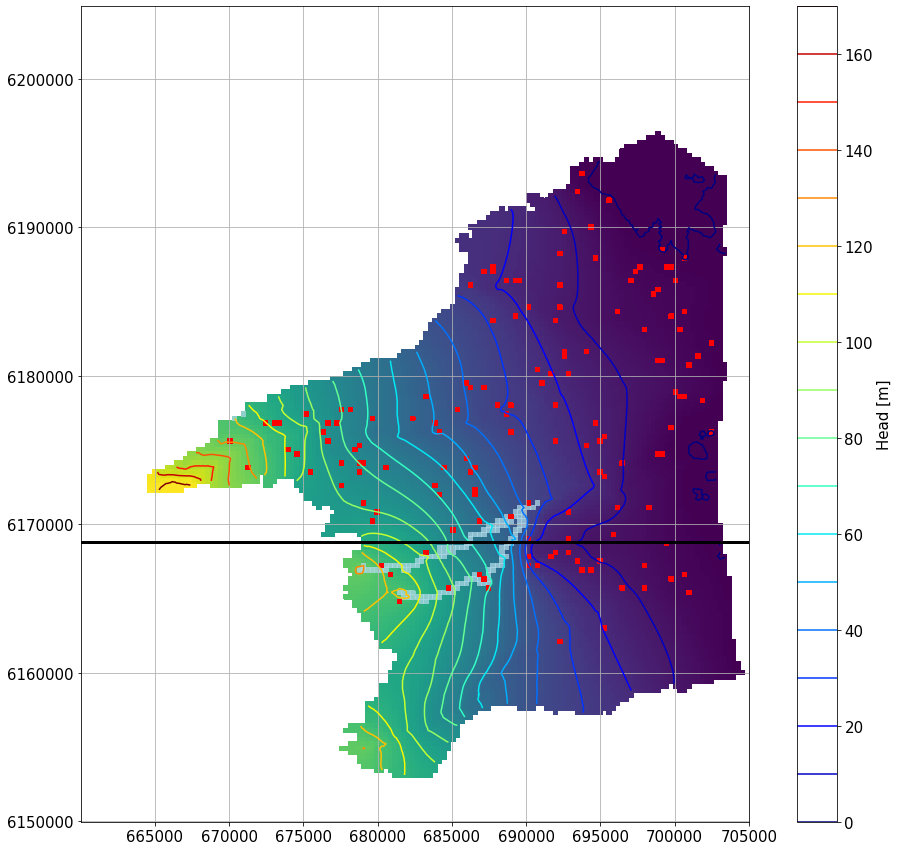

In [131]:
# make a plot
layer = 1
fig = plt.figure(figsize=(17,15))
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)



hmesh=ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
#ml.plot_specific_discharge(spdis[0],color="w",width=0.0050)
cont=ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),cmap="jet")

# plot bc
for bc in bdfile:
    if bc == ("sea") or bc== ("eta"):
        ml.plot_bc(bc,color="b",alpha=0.5)
    else : 
        ml.plot_bc(bc,color="lightblue",alpha=0.5)
ml.plot_bc("wel")

# plot Cross-section
row = 120
x = [x0,x1]
y = [y1-(row+.5)*delc,y1-(row+.5)*delc]
ax.plot(x,y,"k",linewidth=3)


ax.tick_params(labelsize=15)
#ax.tick_params(axis="y",direction="in", pad=-120)

g = plt.colorbar(cont)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()



(-200, 400)

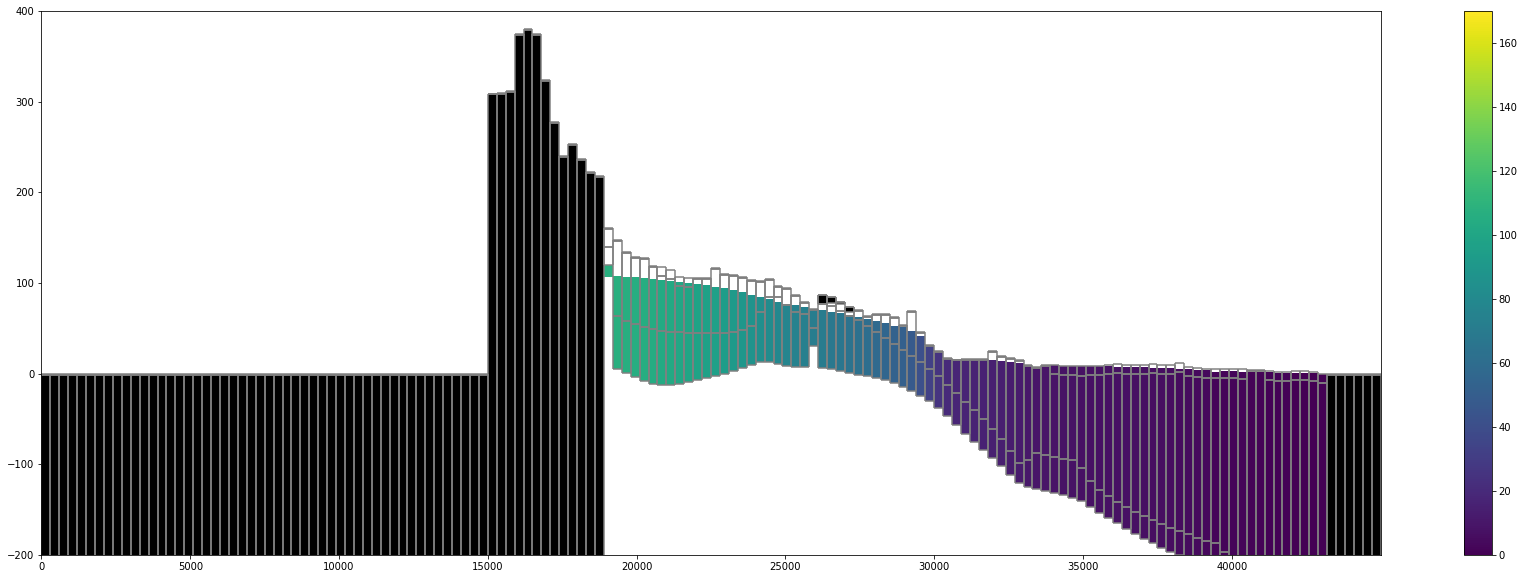

In [92]:
fig,ax = plt.subplots(figsize=(30,10))
x=fp.plot.PlotCrossSection(gwf,line={"row" :row})

arr=x.plot_array(head,masked_values=[1e30],head=head)
plt.colorbar(arr)
arr.set_clim(0,170)
x.plot_ibound()
x.plot_grid()
ax.set_ylim(-200,400)

In [95]:
# Total Budget
lstBudgetfile = "{}.lst".format(model_name)
fname = os.path.join(model_dir,lstBudgetfile)
Budgetobj = fp.utils.Mf6ListBudget(fname)

for i in Budgetobj.entries:
    if i != "PERCENT_DISCREPANCY":
        print("{} : {} m3/s".format(i,Budgetobj.get_budget(names=i)[0][0][-1]))

WEL_IN : 0.0 m3/s
DRN_IN : 0.0 m3/s
RCH_IN : 2.8526999950408936 m3/s
CHD_IN : 1.1842999458312988 m3/s
TOTAL_IN : 9.472299575805664 m3/s
WEL_OUT : 1.3873000144958496 m3/s
DRN_OUT : 3.6270999908447266 m3/s
RCH_OUT : 0.0 m3/s
CHD_OUT : 0.07345499843358994 m3/s
TOTAL_OUT : 9.472700119018555 m3/s
IN-OUT : -0.0003832099901046604 m3/s


In [108]:
Control_pz = Control_Pz.reshape(nlay*nrow*ncol)
head = head.reshape(nlay*nrow*ncol)

Text(0.5, 1.0, 'fit measured vs simulated')

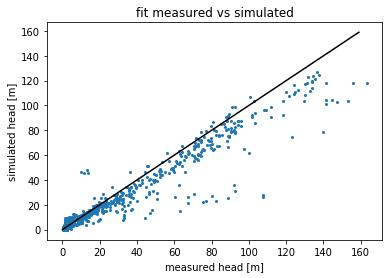

In [109]:
head[head>1000]=None
plt.scatter(Control_pz[Control_pz!=0],
            head[Control_pz!=0],s=4)
plt.plot(np.arange(160),np.arange(160),"k")
plt.xlabel("measured head [m]")
plt.ylabel("simulated head [m]")
plt.title("fit measured vs simulated")

In [110]:
Misfit = np.abs((Control_pz[Control_pz!=0] - head[Control_pz!=0]))
print("Misfit : {} m ".format(np.nanmean(Misfit)))

Misfit : 6.02327713669962 m 


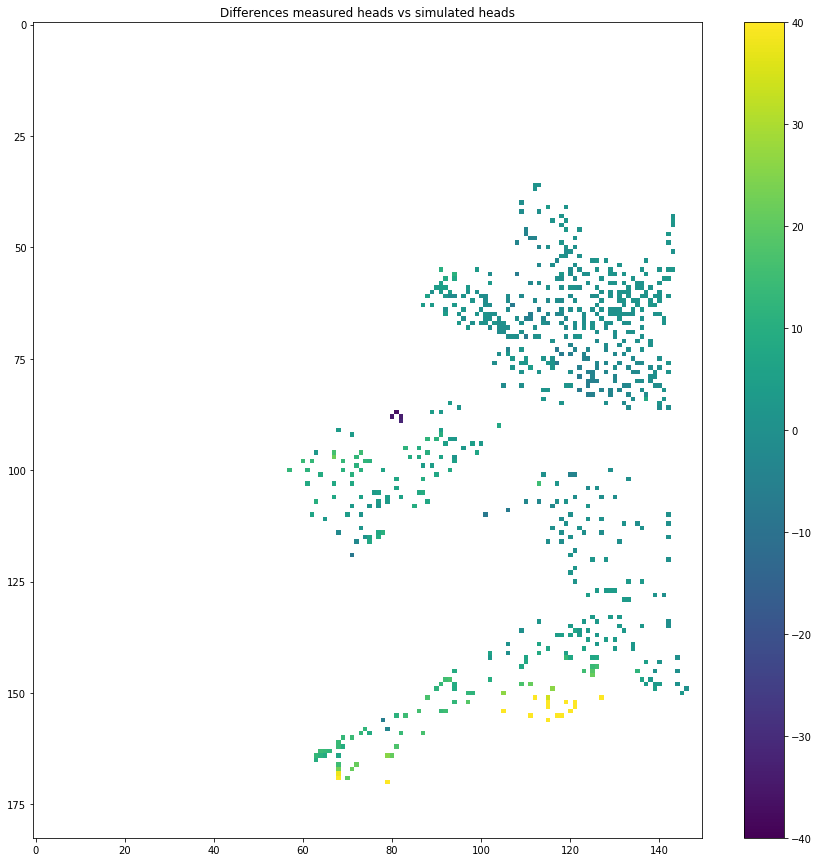

In [129]:
head[Control_pz==0]=None
fig,ax=plt.subplots(figsize=(15,15))
a=plt.imshow((Control_pz - head).reshape(nlay,nrow,ncol)[0])
plt.title("Differences measured heads vs simulated heads")
plt.colorbar()
a.set_clim(-40,40)